In [ ]:

!pip install -q datasets


import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, ViTImageProcessor, ViTModel
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
from datasets import load_dataset


In [ ]:

!pip install -U datasets


In [ ]:
class MultimodalFakeNewsDataset(Dataset):

    def __init__(self, hf_dataset, tokenizer, image_processor, max_length=128):
        self.hf_dataset = hf_dataset
        self.tokenizer = tokenizer
        self.image_processor = image_processor
        self.max_length = max_length

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        # Get a single data point from the Hugging Face dataset
        item = self.hf_dataset[idx]


        text = str(item['text'])
        text_inputs = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Process image (already a PIL object from the dataset)

        image = item['image'].convert('RGB')
        image_inputs = self.image_processor(image, return_tensors='pt') # to simply ensure the image is in RGB format


        return {
            'input_ids': text_inputs['input_ids'].squeeze(),
            'attention_mask': text_inputs['attention_mask'].squeeze(),
            'pixel_values': image_inputs['pixel_values'].squeeze(),
            'label': torch.tensor(item['label'], dtype=torch.long)
        }


In [ ]:
class MultimodalFakeNewsClassifier(nn.Module):
    def __init__(self, num_classes=2, fusion_method='concat'):
        super().__init__()

        # Text encoder
        self.text_encoder = BertModel.from_pretrained('bert-base-uncased')
        self.text_dim = self.text_encoder.config.hidden_size

        # Image encoder
        self.image_encoder = ViTModel.from_pretrained('google/vit-base-patch16-224')
        self.image_dim = self.image_encoder.config.hidden_size

        # Fusion method
        self.fusion_method = fusion_method

        if fusion_method == 'concat':
            # Simple concatenation
            self.fusion_dim = self.text_dim + self.image_dim
            self.classifier = nn.Sequential(
                nn.Linear(self.fusion_dim, 512), nn.ReLU(), nn.Dropout(0.3),
                nn.Linear(512, 128), nn.ReLU(), nn.Dropout(0.3),
                nn.Linear(128, num_classes)
            )
        elif fusion_method == 'attention':
            # Cross-attention fusion
            self.cross_attention = nn.MultiheadAttention(
                embed_dim=self.text_dim, num_heads=8, batch_first=True
            )
            self.fusion_dim = self.text_dim
            self.classifier = nn.Sequential(
                nn.Linear(self.fusion_dim, 256), nn.ReLU(), nn.Dropout(0.3),
                nn.Linear(256, num_classes)
            )
        elif fusion_method == 'bilinear':
            # Bilinear fusion
            self.bilinear = nn.Bilinear(self.text_dim, self.image_dim, 512)
            self.classifier = nn.Sequential(
                nn.ReLU(), nn.Dropout(0.3),
                nn.Linear(512, 128), nn.ReLU(), nn.Dropout(0.3),
                nn.Linear(128, num_classes)
            )

    def forward(self, input_ids, attention_mask, pixel_values):
        # Encode text
        text_outputs = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.last_hidden_state[:, 0, :]

        # Encode image
        image_outputs = self.image_encoder(pixel_values=pixel_values)
        image_features = image_outputs.last_hidden_state[:, 0, :]

        # Fusion
        if self.fusion_method == 'concat':
            fused_features = torch.cat([text_features, image_features], dim=1)
        elif self.fusion_method == 'attention':
            text_query = text_features.unsqueeze(1)
            image_kv = image_features.unsqueeze(1)
            attended_features, _ = self.cross_attention(text_query, image_kv, image_kv)
            fused_features = attended_features.squeeze(1)
        elif self.fusion_method == 'bilinear':
            fused_features = self.bilinear(text_features, image_features)


        logits = self.classifier(fused_features)
        return logits


In [ ]:
class MultimodalTrainer:
    def __init__(self, model, device):
        self.model = model.to(device)
        self.device = device
        self.metrics_history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    def train_epoch(self, dataloader, optimizer, criterion):
        self.model.train()
        total_loss = 0
        for batch in tqdm(dataloader, desc="Training"):
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            pixel_values = batch['pixel_values'].to(self.device)
            labels = batch['label'].to(self.device)

            optimizer.zero_grad()
            outputs = self.model(input_ids, attention_mask, pixel_values)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(dataloader)

    def evaluate(self, dataloader, criterion):
        self.model.eval()
        total_loss = 0
        all_predictions, all_labels = [], []
        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Evaluating"):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                pixel_values = batch['pixel_values'].to(self.device)
                labels = batch['label'].to(self.device)

                outputs = self.model(input_ids, attention_mask, pixel_values)
                loss = criterion(outputs, labels)
                predictions = torch.argmax(outputs, dim=1)
                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                total_loss += loss.item()

        accuracy = accuracy_score(all_labels, all_predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_predictions, average='weighted', zero_division=0
        )
        return {
            'loss': total_loss / len(dataloader), 'accuracy': accuracy, 'precision': precision,
            'recall': recall, 'f1': f1, 'predictions': all_predictions, 'labels': all_labels
        }

    def train(self, train_loader, val_loader, epochs=5, lr=2e-5):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        best_val_acc = 0

        for epoch in range(epochs):
            print(f"\n--- Epoch {epoch+1}/{epochs} ---")
            train_loss = self.train_epoch(train_loader, optimizer, criterion)
            val_metrics = self.evaluate(val_loader, criterion)

            self.metrics_history['train_loss'].append(train_loss)
            self.metrics_history['val_loss'].append(val_metrics['loss'])
            self.metrics_history['val_acc'].append(val_metrics['accuracy'])

            print(f"Train Loss: {train_loss:.4f}")
            print(f"Validation Loss: {val_metrics['loss']:.4f}")
            print(f"Validation Accuracy: {val_metrics['accuracy']:.4f}")
            print(f"Validation F1-Score: {val_metrics['f1']:.4f}")

            if val_metrics['accuracy'] > best_val_acc:
                best_val_acc = val_metrics['accuracy']
                torch.save(self.model.state_dict(), 'best_multimodal_model.pth')
                print("INFO: New best model saved!")
        return self.metrics_history


In [ ]:
def plot_training_metrics(metrics_history):
    """Plot training curves for loss and accuracy."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    epochs = range(1, len(metrics_history['train_loss']) + 1)


    ax1.plot(epochs, metrics_history['train_loss'], 'b-', label='Training Loss')
    ax1.plot(epochs, metrics_history['val_loss'], 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)


    ax2.plot(epochs, metrics_history['val_acc'], 'g-', label='Validation Accuracy')
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy'); ax2.legend(); ax2.grid(True)

    plt.tight_layout()
    plt.savefig('training_metrics.png', dpi=300)
    plt.show()

def plot_confusion_matrix(labels, predictions, class_names=['Real', 'Fake']):
    """Plot and save a confusion matrix."""
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix'); plt.ylabel('True Label'); plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png', dpi=300)
    plt.show()

def generate_detailed_report(labels, predictions, class_names=['Real', 'Fake']):
    """Generate and print a detailed classification report."""
    print("\n" + "="*60 + "\nDETAILED CLASSIFICATION REPORT\n" + "="*60)
    report = classification_report(labels, predictions, target_names=class_names, output_dict=True, zero_division=0)

    print(f"\nOverall Accuracy: {report['accuracy']:.4f}")
    print(f"Macro Average F1: {report['macro avg']['f1-score']:.4f}")
    print(f"Weighted Average F1: {report['weighted avg']['f1-score']:.4f}\n")
    print(f"Per-Class Metrics:")
    for class_name in class_names:
        metrics = report[class_name]
        print(f"  {class_name}:\n    Precision: {metrics['precision']:.4f}\n    Recall: {metrics['recall']:.4f}\n    F1-Score: {metrics['f1-score']:.4f}\n    Support: {metrics['support']}")
    return report


In [ ]:
def main():
    """Complete pipeline from dataset loading to evaluation using Mirage News."""
    print("START: MULTIMODAL FAKE NEWS DETECTION PIPELINE (using anson-huang/mirage-news)")
    print("="*70)


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"INFO: Using device: {device}")
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    image_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')


    print("\nINFO: Loading 'anson-huang/mirage-news' dataset with all splits...")
    try:
        ds = load_dataset("anson-huang/mirage-news", download_mode="force_redownload")
    except Exception as e:
        print(f"ERROR: Failed to load dataset. Details: {e}")
        return


    print(f"Dataset splits available: {list(ds.keys())}")



    if 'train' in ds and 'validation' in ds and 'test' in ds:
        train_hf = ds['train']
        val_hf = ds['validation']
        test_hf = ds['test']
    else:

        print("INFO: Validation split not found, splitting dataset manually...")
        full_dataset = ds['train'] if 'train' in ds else ds[list(ds.keys())[0]]
        train_test_split = full_dataset.train_test_split(test_size=0.3, seed=42)
        train_hf = train_test_split['train']
        temp_hf = train_test_split['test']
        val_test_split = temp_hf.train_test_split(test_size=0.5, seed=42)
        val_hf = val_test_split['train']
        test_hf = val_test_split['test']

    print(f"Dataset sizes - Train: {len(train_hf)}, Validation: {len(val_hf)}, Test: {len(test_hf)}")


    print("\nINFO: Creating PyTorch DataLoaders...")
    train_dataset = MultimodalFakeNewsDataset(train_hf, tokenizer, image_processor)
    val_dataset = MultimodalFakeNewsDataset(val_hf, tokenizer, image_processor)
    test_dataset = MultimodalFakeNewsDataset(test_hf, tokenizer, image_processor)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)


    fusion_methods = ['concat', 'attention', 'bilinear']
    results, all_histories = {}, {}
    for fusion_method in fusion_methods:
        print(f"\n--- Training with {fusion_method.upper()} fusion ---")
        model = MultimodalFakeNewsClassifier(fusion_method=fusion_method)
        trainer = MultimodalTrainer(model, device)
        metrics_history = trainer.train(train_loader, val_loader, epochs=3, lr=2e-5)

        print(f"INFO: Evaluating {fusion_method.upper()} on the test set with the best saved model...")
        model.load_state_dict(torch.load('best_multimodal_model.pth'))
        tester = MultimodalTrainer(model, device)

        test_metrics = tester.evaluate(test_loader, nn.CrossEntropyLoss())
        results[fusion_method] = test_metrics
        all_histories[fusion_method] = metrics_history
        print(f"RESULT ({fusion_method.upper()}): Test Accuracy: {test_metrics['accuracy']:.4f}, Test F1-Score: {test_metrics['f1']:.4f}")


    print("\n" + "="*70 + "\nFINAL COMPARISON OF FUSION METHODS\n" + "="*70)
    best_method = max(results, key=lambda x: results[x]['accuracy'])
    for method, metrics in results.items():
        marker = 'BEST ->' if method == best_method else '       '
        print(f"{marker} {method.upper()}: Accuracy={metrics['accuracy']:.4f}, F1={metrics['f1']:.4f}")

    # best model loading
    print(f"\nINFO: Generating report and visualizations for the best method: {best_method.upper()}...")
    best_metrics = results[best_method]
    best_history = all_histories[best_method]

    plot_training_metrics(best_history)
    plot_confusion_matrix(best_metrics['labels'], best_metrics['predictions'])
    generate_detailed_report(best_metrics['labels'], best_metrics['predictions'])

    print(f"\nPIPELINE FINISHED. Best model ({best_method.upper()}) state is saved as 'best_multimodal_model.pth'")


START: MULTIMODAL FAKE NEWS DETECTION PIPELINE (using anson-huang/mirage-news)
INFO: Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



INFO: Loading 'anson-huang/mirage-news' dataset with all splits...


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/655M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/143M [00:00<?, ?B/s]

test1_nyt_mj-00000-of-00001.parquet:   0%|          | 0.00/20.2M [00:00<?, ?B/s]

test2_bbc_dalle-00000-of-00002.parquet:   0%|          | 0.00/560M [00:00<?, ?B/s]

test2_bbc_dalle-00001-of-00002.parquet:   0%|          | 0.00/19.0M [00:00<?, ?B/s]

test3_cnn_dalle-00000-of-00002.parquet:   0%|          | 0.00/559M [00:00<?, ?B/s]

test3_cnn_dalle-00001-of-00002.parquet:   0%|          | 0.00/25.8M [00:00<?, ?B/s]

test4_bbc_sdxl-00000-of-00001.parquet:   0%|          | 0.00/46.0M [00:00<?, ?B/s]

test5_cnn_sdxl-00000-of-00001.parquet:   0%|          | 0.00/54.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2500 [00:00<?, ? examples/s]

Generating test1_nyt_mj split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test2_bbc_dalle split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test3_cnn_dalle split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test4_bbc_sdxl split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test5_cnn_sdxl split:   0%|          | 0/500 [00:00<?, ? examples/s]

Dataset splits available: ['train', 'validation', 'test1_nyt_mj', 'test2_bbc_dalle', 'test3_cnn_dalle', 'test4_bbc_sdxl', 'test5_cnn_sdxl']
INFO: Validation split not found, splitting dataset manually...
Dataset sizes - Train: 7000, Validation: 1500, Test: 1500

INFO: Creating PyTorch DataLoaders...

--- Training with CONCAT fusion ---


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/3 ---


Evaluating: 100%|██████████| 94/94 [00:31<00:00,  3.02it/s]


Train Loss: 0.2590
Validation Loss: 0.0921
Validation Accuracy: 0.9700
Validation F1-Score: 0.9700
INFO: New best model saved!

--- Epoch 2/3 ---


Evaluating: 100%|██████████| 94/94 [00:31<00:00,  3.01it/s]


Train Loss: 0.0280
Validation Loss: 0.0724
Validation Accuracy: 0.9733
Validation F1-Score: 0.9733
INFO: New best model saved!

--- Epoch 3/3 ---


Evaluating: 100%|██████████| 94/94 [00:31<00:00,  3.02it/s]


Train Loss: 0.0153
Validation Loss: 0.1109
Validation Accuracy: 0.9673
Validation F1-Score: 0.9673
INFO: Evaluating CONCAT on the test set with the best saved model...


Evaluating: 100%|██████████| 94/94 [00:31<00:00,  3.01it/s]


RESULT (CONCAT): Test Accuracy: 0.9720, Test F1-Score: 0.9720

--- Training with ATTENTION fusion ---


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/3 ---


Evaluating: 100%|██████████| 94/94 [00:31<00:00,  3.01it/s]


Train Loss: 0.2565
Validation Loss: 0.0960
Validation Accuracy: 0.9620
Validation F1-Score: 0.9620
INFO: New best model saved!

--- Epoch 2/3 ---


Evaluating: 100%|██████████| 94/94 [00:31<00:00,  3.02it/s]


Train Loss: 0.0494
Validation Loss: 0.0869
Validation Accuracy: 0.9700
Validation F1-Score: 0.9700
INFO: New best model saved!

--- Epoch 3/3 ---


Evaluating: 100%|██████████| 94/94 [00:31<00:00,  3.01it/s]


Train Loss: 0.0170
Validation Loss: 0.1642
Validation Accuracy: 0.9513
Validation F1-Score: 0.9512
INFO: Evaluating ATTENTION on the test set with the best saved model...


Evaluating: 100%|██████████| 94/94 [00:31<00:00,  3.02it/s]


RESULT (ATTENTION): Test Accuracy: 0.9660, Test F1-Score: 0.9660

--- Training with BILINEAR fusion ---


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/3 ---


Evaluating: 100%|██████████| 94/94 [00:32<00:00,  2.87it/s]


Train Loss: 0.2695
Validation Loss: 0.0830
Validation Accuracy: 0.9673
Validation F1-Score: 0.9673
INFO: New best model saved!

--- Epoch 2/3 ---


Evaluating: 100%|██████████| 94/94 [00:33<00:00,  2.83it/s]


Train Loss: 0.0575
Validation Loss: 0.0809
Validation Accuracy: 0.9733
Validation F1-Score: 0.9733
INFO: New best model saved!

--- Epoch 3/3 ---


Evaluating: 100%|██████████| 94/94 [00:32<00:00,  2.85it/s]


Train Loss: 0.0189
Validation Loss: 0.0876
Validation Accuracy: 0.9767
Validation F1-Score: 0.9767
INFO: New best model saved!
INFO: Evaluating BILINEAR on the test set with the best saved model...


Evaluating: 100%|██████████| 94/94 [00:34<00:00,  2.71it/s]


RESULT (BILINEAR): Test Accuracy: 0.9780, Test F1-Score: 0.9780

FINAL COMPARISON OF FUSION METHODS
        CONCAT: Accuracy=0.9720, F1=0.9720
        ATTENTION: Accuracy=0.9660, F1=0.9660
BEST -> BILINEAR: Accuracy=0.9780, F1=0.9780

INFO: Generating report and visualizations for the best method: BILINEAR...


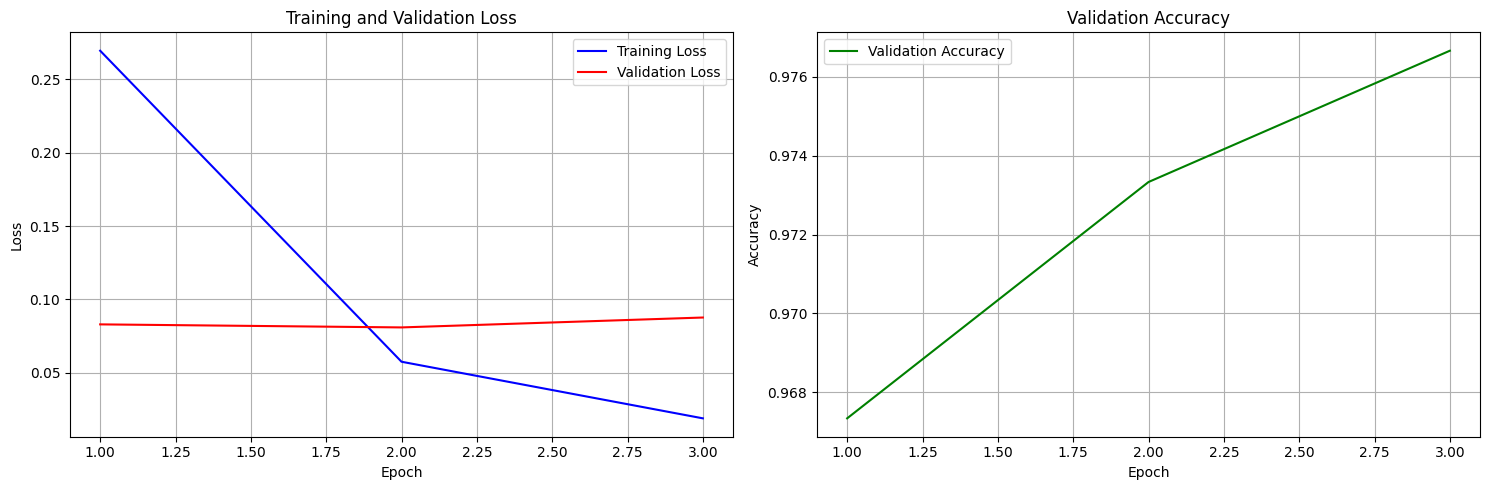

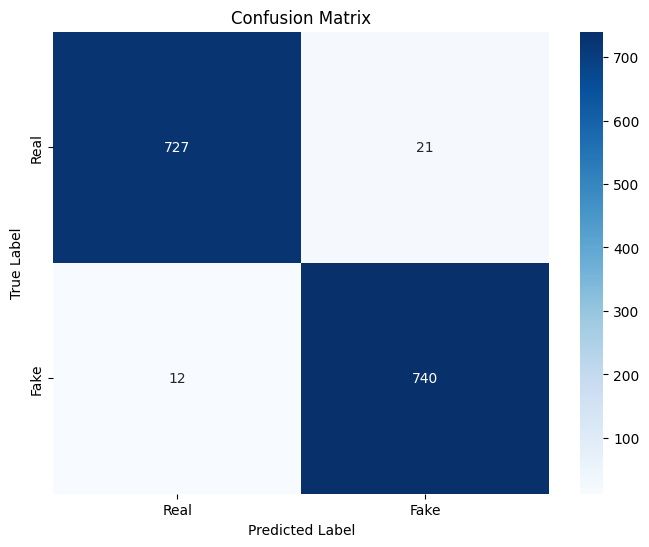


DETAILED CLASSIFICATION REPORT

Overall Accuracy: 0.9780
Macro Average F1: 0.9780
Weighted Average F1: 0.9780

Per-Class Metrics:
  Real:
    Precision: 0.9838
    Recall: 0.9719
    F1-Score: 0.9778
    Support: 748.0
  Fake:
    Precision: 0.9724
    Recall: 0.9840
    F1-Score: 0.9782
    Support: 752.0

PIPELINE FINISHED. Best model (BILINEAR) state is saved as 'best_multimodal_model.pth'


In [ ]:
# Execute the main function
main()


In [ ]:

import random
import textwrap
import numpy as np
import matplotlib.pyplot as plt

print("--- Starting Post-Training Error Analysis ---")



def visualize_model_errors(labels, predictions, probabilities, hf_dataset, num_samples=4, class_names=['Real', 'Fake']):
    """
    Visualizes a random sample of correct and incorrect predictions,
    showing the image, text, and prediction confidence.
    """
    labels, predictions = np.array(labels), np.array(predictions)

    tp_indices = np.where((predictions == 1) & (labels == 1))[0]
    tn_indices = np.where((predictions == 0) & (labels == 0))[0]
    fp_indices = np.where((predictions == 1) & (labels == 0))[0]
    fn_indices = np.where((predictions == 0) & (labels == 1))[0]

    prediction_groups = {
        "False Positives (Real as Fake)": fp_indices,
        "False Negatives (Fake as Real)": fn_indices,
        "True Positives (Correct Fakes)": tp_indices,
        "True Negatives (Correct Reals)": tn_indices,
    }

    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5 * num_samples))
    fig.suptitle("Model Prediction Analysis", fontsize=24)

    for i, (title, indices) in enumerate(prediction_groups.items()):
        axes[0, i].set_title(title, fontsize=14, pad=20)

        if len(indices) == 0:
            axes[0,i].text(0.5, 0.5, "None", ha='center', va='center', transform=axes[0,i].transAxes, fontsize=12, color='gray')
            for j in range(num_samples):
                axes[j,i].axis('off')
            continue

        sample_indices = random.sample(list(indices), min(num_samples, len(indices)))

        for j in range(num_samples):
            ax = axes[j, i]
            ax.axis('off')
            if j < len(sample_indices):
                idx = sample_indices[j]
                item = hf_dataset[int(idx)]

                image = item['image']
                text = item['text']
                true_label = class_names[labels[idx]]
                pred_label = class_names[predictions[idx]]
                confidence = probabilities[idx][predictions[idx]]

                ax.imshow(image)


                wrapped_text = '\n'.join(textwrap.wrap(text, width=30))


                subtitle = (
                    f"True: {true_label} | Predicted: {pred_label}\n"
                    f"Confidence: {confidence:.2%}\n\n"
                    f"Text: {wrapped_text}"
                )


                ax.text(0.5, -0.15, subtitle, ha='center', va='top', transform=ax.transAxes, fontsize=9)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('error_analysis_visualization.png', dpi=300)
    plt.show()


class MultimodalTrainer:
    def __init__(self, model, device):
        self.model = model.to(device)
        self.device = device

    def evaluate(self, dataloader, criterion):
        self.model.eval()
        total_loss = 0
        all_predictions, all_labels, all_probabilities = [], [], []
        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Evaluating"):
                input_ids, attention_mask, pixel_values, labels = (
                    batch['input_ids'].to(self.device),
                    batch['attention_mask'].to(self.device),
                    batch['pixel_values'].to(self.device),
                    batch['label'].to(self.device)
                )
                outputs = self.model(input_ids, attention_mask, pixel_values)
                loss = criterion(outputs, labels)
                probabilities = torch.softmax(outputs, dim=1)
                predictions = torch.argmax(probabilities, dim=1)
                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probabilities.append(probabilities.cpu().numpy())
                total_loss += loss.item()
        all_probabilities = np.concatenate(all_probabilities, axis=0)
        accuracy = accuracy_score(all_labels, all_predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted', zero_division=0)
        return {'loss': total_loss / len(dataloader), 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'predictions': all_predictions, 'labels': all_labels, 'probabilities': all_probabilities}



BEST_FUSION_METHOD = 'bilinear'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"INFO: Loading best model with '{BEST_FUSION_METHOD}' fusion...")

inference_model = MultimodalFakeNewsClassifier(fusion_method=BEST_FUSION_METHOD)
try:
    inference_model.load_state_dict(torch.load('best_multimodal_model.pth'))
    inference_model.to(device)
    print("SUCCESS: Model weights loaded successfully.")
except Exception as e:
    print(f"ERROR: Could not load model weights. Details: {e}")

# --- 3. RELOAD THE TEST DATASET ---
print("\nINFO: Reloading dataset to get the test set...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
image_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
full_dataset = load_dataset("anson-huang/mirage-news", split='train')
train_test_split = full_dataset.train_test_split(test_size=0.3, seed=42)
temp_hf = train_test_split['test']
val_test_split = temp_hf.train_test_split(test_size=0.5, seed=42)
test_hf = val_test_split['test']
print(f"SUCCESS: Test set with {len(test_hf)} samples is ready.")

print("\nINFO: Evaluating the loaded model on the test set...")
test_dataset = MultimodalFakeNewsDataset(test_hf, tokenizer, image_processor)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
trainer_for_eval = MultimodalTrainer(inference_model, device)
test_metrics = trainer_for_eval.evaluate(test_loader, nn.CrossEntropyLoss())
print("SUCCESS: Evaluation complete.")


print("\nINFO: Generating the visual error analysis report...")
if 'probabilities' in test_metrics:
    visualize_model_errors(
        labels=test_metrics['labels'],
        predictions=test_metrics['predictions'],
        probabilities=test_metrics['probabilities'],
        hf_dataset=test_hf,
        num_samples=4
    )
else:
    print("ERROR: 'probabilities' key is missing. Please check the MultimodalTrainer definition.")

print("\n--- Error Analysis Complete ---")

